# Deep LPBM for Block clustering and Latent representation of nodes in networks (Boutin et al., 2025)
**Introduction to Probabilistic Graphical Models and Deep Generative Models (MVA 2025-2026)**  

**Student:** Karina Musina
**Email:** karina.musina@student-cs.fr
**Student:** Yannaël Bossard
**Email:** yannael.bossard@ens-paris-saclay.fr  
**Report Deadline:** 17 / 12 / 2025
**Poster Deadline:** 18 / 12 / 2025


### Objective:
This notebook aimes to re-implement the framework for studying graph-structured data, proposed by Boutin et al. (2025). They introduced a novel model, called Deep Latent Position Block Model (Deep LPBM), that simultaneously performs node clustering and interpretable visualization of the network in a latent space. The models is claimed to capture diverse connectivity structures and estimates partial node memberships.

Studied paper: https://doi.org/10.1007/s11222-025-10679-7
Further explaination: https://hal.science/hal-04910241v1/document


### summary:
1.   Benchmarks
2.   Encoder
3.   Decoder
4.   DeepLPBM
5.   Pretraining
5.   Training
6.   main
7.   Evaluation
8.   Evaluation



Warning: There may be some typo in the notebook, where we call $\Pi^0$ the Pi_kmean, and vice-versa. Because the decoder is frozen during the pretraining, it's actually the same matrix.




### Libraries

In [ ]:
from logging import debug
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches
import warnings
from sklearn.manifold import TSNE
import networkx as nx

import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

try:
  from torch_geometric.nn import GCNConv
  from torch_geometric.utils import dense_to_sparse
except:
  !pip install torch_geometric
  from torch_geometric.nn import GCNConv
  from torch_geometric.utils import dense_to_sparse

try:
  import umap
except:
  !pip install umap-learn
  import umap

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

debug_mode = False


def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(11)

Using device: cuda


## I- Benchmarks

Implementation and visualization of Assortative/Disassortative/Hub graphs

In [ ]:
def create_connect_matrix(graph_struct="disassortative", n_clusters=5, Beta=0.3, Epsi = 0.05, undirected=True):
  '''
  This function generates the connectivity matrix of a graph with n_clusters clusters as described in the paper Sec.5

  Parameters-->
  n_clusters: Number of clusters in the graph.
  graph_struct: Graph structure you want to generate between "disassortative"/"assortative"/"hub"
  Beta : Parameter for the probability/strength of connectivity
  Epsi : Parameter for the probability/strength of unconnectivity

  Returns-->
  connectivity_matrix : (np.array) Connectivity matrix $\Pi$ of the graph.
  '''

  # Create connectivity matrix
  connectivity_matrix = np.zeros((n_clusters, n_clusters))

  if graph_struct=="assortative":
    ### COMMUNITIES-like graph
    for i in range(n_clusters):
      for j in range(n_clusters):
        if i == j:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Beta, 0.02), 0, 3*Beta)
        else:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Epsi, 0.01), 0, 3*Epsi)

  elif graph_struct=="disassortative":
    ### DISASSORTATIVE-like graph
    for i in range(n_clusters):
      for j in range(n_clusters):
        if i == j:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Epsi, 0.01), 0, 3*Epsi)
        else:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Beta, 0.02), 0, 3*Beta)

  elif graph_struct=="hub":
    ### HUB-like graph
    for i in range(n_clusters):
      for j in range(n_clusters):

        if i == j:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Beta, 0.01), 0, 3*Beta)
        else:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Epsi, 0.02), 0, 3*Epsi)
    fully_connected_cluster = np.random.choice(n_clusters, size=1, replace=False)
    connectivity_matrix[fully_connected_cluster, :] = np.clip(np.random.normal(Beta, 0.02,size=(1, n_clusters)), 0, 3*Beta)
    connectivity_matrix[:,fully_connected_cluster] = np.clip(np.random.normal(Beta, 0.02,size=(n_clusters,1)), 0, 3*Beta)

  else:
    raise ValueError("Invalid graph structure! You have to select among 'assortative'/'disassortative'/'hub' ...")


  #raise ValueError(" Watch out, check out the course, the connectivity matrix should be symmetric because the adjacency matrix is ")
  if undirected:
    connectivity_matrix = 0.5*(connectivity_matrix + connectivity_matrix.T) # ensure it's symmetric
  else:
    pass # directivity will be induced only by the additional random noise

  return connectivity_matrix


def create_simple_graph(n_nodes, n_clusters,graph_struct="disassortative", undirected=True, Beta=0.3, Epsi=0.05, Zeta=0.99, shuffle=False, plot=False):
  '''
  This function creates a simple graph structure with n_nodes nodes and n_clusters clusters as described in the paper Sec.5

  Parameters-->
  n_nodes: Number of nodes in the graph.
  n_clusters: Number of clusters in the graph.
  graph_struct: Graph structure. The default is "disassortative".
  undirected: Whether the graph is undirected or not. The default is True as in the paper
  n_clusters: Number of clusters in the graph.
  graph_struct: Graph structure you want to generate between "disassortative"/"assortative"/"hub"
  Beta : Parameter for the probability/strength of connectivity
  Epsi : Parameter for the probability/strength of unconnectivity
  Zeta: Add some noise/uniformity to the latent connectivity per nodes.
  shuffle: Whether to shuffle the adjacency matrix or not.
  plot: (boolean) Whether to plot the graph or not

  Returns-->
  Adja_matrix: (np.array) Adjacency matrix of the graph. (size=(n_nodes,n_nodes))
  connectivity_matrix : (np.array) Connectivity matrix $\Pi$ of the graph. (size=(n_clusters,n_clusters))
  eta_star:  (np.array) latent connectivity per nodes (size=(n_nodes,n_clusters))
  '''

  # Create connectivity metrix
  Pi_connectivity_matrix = create_connect_matrix(graph_struct=graph_struct, n_clusters=n_clusters, Beta=Beta, Epsi = Epsi,undirected=undirected)

  # η ∈ R^{N×Q} with rows on the simplex.
  eta_onehot = np.zeros((n_nodes,n_clusters))
  # Lets assume a equidistributed population among clusters
  nodes_label = np.repeat(np.arange(n_clusters), n_nodes // n_clusters)
  nodes_label = np.concatenate([nodes_label, nodes_label[-1]*np.ones(n_nodes-len(nodes_label))]).astype(np.int32)

  for i,label in enumerate(nodes_label):
    eta_onehot[i,label] = 1

  eta_unif = np.full((n_nodes, n_clusters), (1.0 - Zeta) / n_clusters, dtype=float)
  eta_star = Zeta*eta_onehot + eta_unif

  P = eta_star @ Pi_connectivity_matrix @ eta_star.T # probability matrix of connectivity

  # Create the adjacency matrix of the graph
  Adja_matrix = np.zeros((n_nodes, n_nodes))

  if undirected: # Adja_matrix is symmetric
    for i in range(n_nodes):
      for j in range(i+1, n_nodes):
        Aij = np.random.binomial(1, P[i, j])
        Adja_matrix[i, j] = Aij
        Adja_matrix[j, i] = Aij  # symmetry

  if not undirected: # Adja_matrix is not necessarily symmetric
    for i in range(n_nodes):
      for j in range(n_nodes):
        if i != j:
          Aij = np.random.binomial(1, P[i, j])
          Adja_matrix[i, j] = Aij


  # Compute density:
  density = np.sum(Adja_matrix) / (n_nodes * (n_nodes - 1))
  #print("density = ", density)

  if shuffle:
    perm_indices = np.random.permutation(n_nodes)

    # suffle Rows & Columns to preserve graph topology
    Adja_matrix = Adja_matrix[perm_indices, :]
    Adja_matrix = Adja_matrix[:, perm_indices]

    # Apply the SAME permutation to the ground truth labels
    eta_star = eta_star[perm_indices, :]
    nodes_label = nodes_label[perm_indices]

  if plot:

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Connectivity matrix
    im0 = axes[0].imshow(Pi_connectivity_matrix, interpolation='nearest')
    axes[0].set_title("Connectivity matrix Π")
    axes[0].set_xlabel("cluster")
    axes[0].set_ylabel("cluster")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Adjacency matrix
    im1 = axes[1].imshow(Adja_matrix, interpolation='nearest')
    axes[1].set_title("Adjacency matrix A")
    axes[1].set_xlabel("node")
    axes[1].set_ylabel("node")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    fig.suptitle(f" {graph_struct} graph structure Instance, density={density:.3f}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


  return Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label




<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:81: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:81: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-1387598252.py:12: SyntaxWarning: invalid escape sequence '\P'
  connectivity_matrix : (np.array) Connectivity matrix $\Pi$ of the graph.
/tmp/ipython-input-1387598252.py:81: SyntaxWarning: invalid escape sequence '\P'
  connectivity_matrix : (np.array) Connectivity matrix $\Pi$ of the graph. (size=(n_clusters,n_clusters))


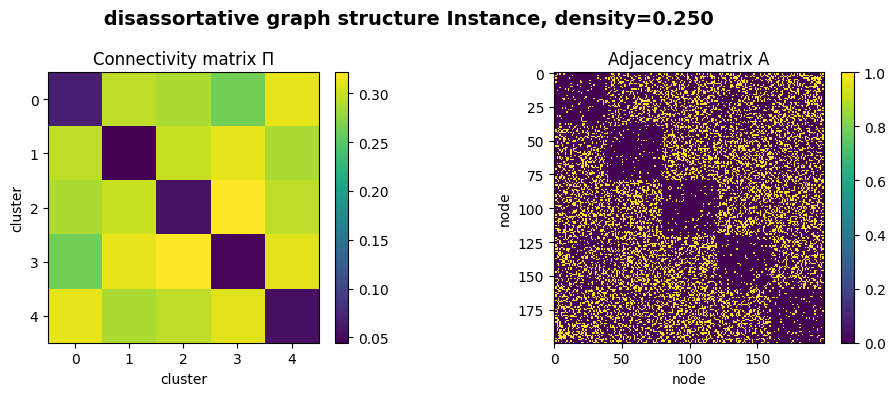

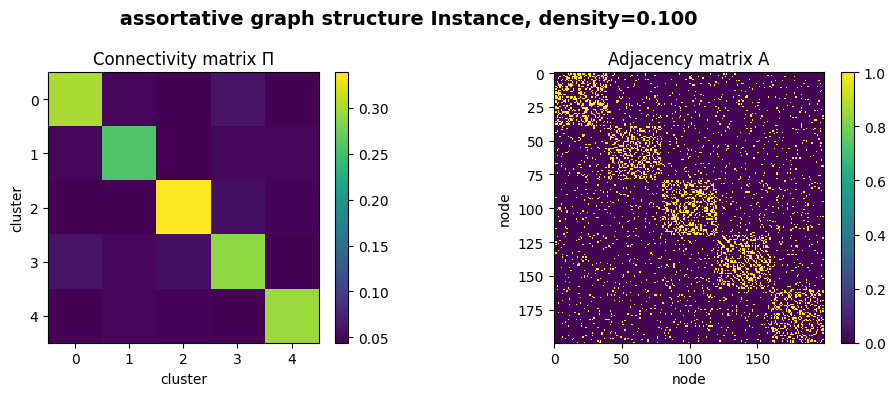

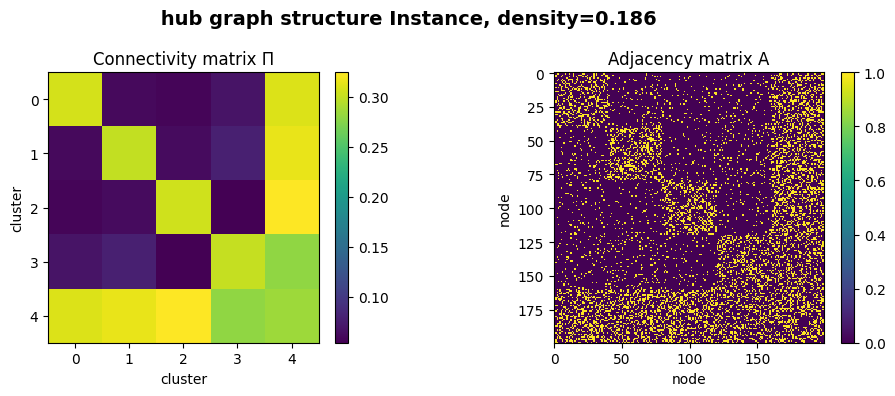

In [ ]:
Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label = create_simple_graph(n_nodes=200, n_clusters=5,graph_struct="disassortative", undirected=True, Beta=0.3, Epsi=0.05, Zeta=0.99, shuffle=False, plot=True)
Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label = create_simple_graph(n_nodes=200, n_clusters=5,graph_struct="assortative", undirected=True, Beta=0.3, Epsi=0.05, Zeta=0.99, shuffle=False, plot=True)
Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label = create_simple_graph(n_nodes=200, n_clusters=5,graph_struct="hub", undirected=True, Beta=0.3, Epsi=0.05, Zeta=0.99, shuffle=False, plot=True)

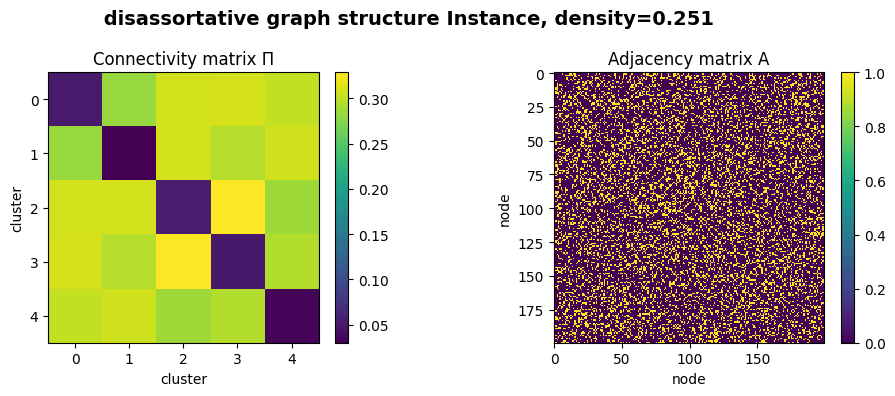

In [ ]:
Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label = create_simple_graph(n_nodes=200, n_clusters=5,graph_struct="disassortative", undirected=True, Beta=0.3, Epsi=0.05, Zeta=0.99, shuffle=True, plot=True)


## Encoder

The encoder is Graph Convolutional Network. It learns node embeddings (latent variables zi), and then maps them to probabilistic cluster memberships  ηi=softmax(zi)
	​

Visual explanation: https://www.youtube.com/watch?v=eLcGehfjvgs
Course: https://weizhewei.com/assets/pdf/GCN_theory_short%20v6.pdf
sources: https://arxiv.org/abs/1609.02907 (Kipf and Welling, 2017)



**Encoder:** The inference model $q_\phi(Z|A)$ is parameterized by a Graph Convolutional Network (GCN). The encoder takes the adjacency matrix $A$ (and optionally node features $X=I_N$) as input and outputs the parameters of the variational distribution, assumed to be Gaussian (total factorisation assumption):
\begin{equation}
    q_\phi(Z|A) = \prod_{i=1}^N \mathcal{N}(z_i; \mu_{\phi,i}(A), \text{diag}(\sigma_{\phi,i}^2(A)))
\end{equation}
The GCN aggregates neighbor information to compute the means $\mu_\phi$ and variances $\sigma_\phi^2$, effectively embedding structural information into the latent space $Z$.

In [ ]:
def normalize_adj_Ltilde(A):
  '''
  L˜ = D˜^{−1/2}A˜D˜^{−1/2}, which serves as a renormalisation trick to avoid numerical instability (Kingma and Ba 2014).
  '''
  N = A.size(0)
  In = torch.eye(N, device=A.device, dtype=A.dtype)
  A_tilde = A + In
  D_ii_vect = A_tilde.sum(dim=1) # degree matrix/vector
  D_ii_sqrt = torch.pow(D_ii_vect, -0.5)
  D_ii_sqrt[torch.isinf(D_ii_sqrt)] = 0.0 # Handle inf cases
  D_sqrt = torch.diag(D_ii_sqrt)
  L_tilde = D_sqrt @ A_tilde @ D_sqrt
  return L_tilde


def centred_softmax(z, eps=1e-16):
  '''
  probability of belonging to cluster q. Each node has a Q-dimensional vector y

  Z is (N, Q-1)
  '''
  c = z.max(dim=-1, keepdim=True).values # "LogSumExp" trick to prevent overflow
  z_shift = z - c
  ez = torch.exp(z_shift)

  denom = torch.exp(-c) + ez.sum(dim=-1, keepdim=True)

  y_1toQ = ez / (denom + eps) # exp(z_shift)/denom = exp(z).exp(-c)/(exp(-c).S(z))=exp(z)/S(z)
  y_Q = torch.exp(-c) / (denom + eps)

  return torch.cat([y_1toQ, y_Q], dim=-1)


#def centred_softmax(z):
#  '''
#  probability of belonging to cluster q. Each node has a Q-dimensional vector y
#
#  Z is (N, Q-1)
#  '''
#  z = z - z.max(dim=-1, keepdim=True).values # preventing overflow => Softmax is invariant to additive constants (exp(zi-C)/sum(zi-C) = (exp(zi)/sum(zi))
#  ez = torch.exp(z)
#  S = 1.0 + ez.sum(dim=-1, keepdim=True)
#  y_1toQ = ez / S
#  y_Q = 1.0 / S

#  return torch.cat([y_1toQ, y_Q], dim=-1)



def glorot_init(input_dim, output_dim):
  '''
  Taken from https://github.com/Remi-Boutin/deeplptm_package/tree/main
  '''
  init_range = np.sqrt(6.0 / (input_dim + output_dim))
  initial = torch.rand(input_dim, output_dim, dtype = torch.float32) * 2 * init_range - init_range
  initial = initial.to(device)
  return nn.Parameter(initial)

class GCN_encoder(nn.Module): # The class must inherit from nn.Module so that PyTorch recognize forward as the execution method
  '''
  It consists of a two-layer GCN producing the (Q − 1)-dimensional mean vectors (μφ(A)i )i
  as well as the scalar log standard deviations (log σφ(A)i )i .
      φ = {W0,Wμ,Wσ }, the VGAE parameters

  Input features X default to I (N×N), so W0: (N,H).
  Heads Wμ, Wσ: (H, Q-1).

  '''
  def __init__(self, N, Q_minus_1, H=30):
    super().__init__()
    self.N = N
    self.H = H
    self.Qm1 = Q_minus_1
    # φ = {W0,Wμ,Wσ }, the VGAE parameters
    self.W0 = glorot_init(N, H)
    self.W_mu = glorot_init(H, Q_minus_1)
    self.W_sigma = glorot_init(H, 1)  ## Ambiguity in the paper about the dimension of W_sigma being (H, 1) or (H, Q-1)


  def forward(self, A):
    L_tilde = normalize_adj_Ltilde(A) # Normalized adjacency matrix (N,N) (GCN uses to aggregate neighbor information).
    #X = torch.eye(self.N, device=A.device) # Node features = identity in our case
    #H1 = F.relu(L_tilde @ X @ self.W0) # First GCN layer (N,H)
    H1 = F.relu(L_tilde @ self.W0) # First GCN layer (N,H), we don't need the X as long as it's identity
    '''=> aggregates each node’s features from its neighbors (via L_tilde) then multiplied by learnable linear transform to leverage
    features/connection importance. Then, add non-linearity with ReLU'''
    mu = L_tilde @ H1 @ self.W_mu # Second GCN layer (mean head) (N,Q-1)
    log_sigma = L_tilde @ H1 @ self.W_sigma # Second GCN layer (variance head) (N,Q-1) or (N,1)
    ## ! The 2nd layer doesn't have activation function

    return mu, log_sigma


def get_membership_eta(mu, log_sigma):
  '''
  Samples Z and computes memberships matrix η using the reparameterization trick.
  '''
  sigma = torch.exp(log_sigma) # (N, Q-1)
  eps = torch.randn_like(mu) # mean 0 and variance 1.
  Z = mu + sigma * eps # reparametrization trick from equation 12, Monte Carlo sampling with k=1; (N, Q-1),
  eta = centred_softmax(Z) # (N, Q), from equation 3

  return Z, eta



In [ ]:

class GCNEncoderPyG(nn.Module):
    '''
    Encoder VGAE GCNConv (PyTorch Geometric).

    - X = I_N (one-hot node features)
    - conv1 embedding H
    - mu_layer : H -> (Q-1)
    - sigma_layer : H -> 1 (sigma scalar)
    '''
    def __init__(self, N, Q_minus_1, H=30):
        super().__init__()
        self.N = N
        self.Qm1 = Q_minus_1
        self.H = H

        # 1st GCN layer : N -> H (X = I_N => F_in = N)
        self.conv1 = GCNConv(in_channels=N, out_channels=H)

        # Heads
        self.mu_layer = nn.Linear(H, Q_minus_1)
        self.sigma_layer = nn.Linear(H, 1)

    def forward(self, A):
        '''
        A : adjacency dense (N,N)
        '''
        N = A.size(0)
        device = A.device

        # Node features = I_N
        x = torch.eye(N, device=device)

        # Conversion PyG
        # edge_index : (2, E), edge_weight : (E,)
        edge_index, edge_weight = dense_to_sparse(A)

        # GCN layer (Kipf & Welling + normalisation)
        h = self.conv1(x, edge_index, edge_weight)
        h = F.relu(h)  # (N, H)

        # Heads
        mu = self.mu_layer(h)         # (N, Q-1)
        log_sigma = self.sigma_layer(h)  # (N, 1)

        return mu, log_sigma


In [ ]:
class GCNEncoderPyG2Layers(nn.Module):
  '''
  Simple test to check if that change significantly something

  '''
  def __init__(self, N, Q_minus_1, H=30):
      super().__init__()
      self.conv1      = GCNConv(in_channels=N, out_channels=H)
      self.conv_mu    = GCNConv(in_channels=H, out_channels=Q_minus_1)
      self.conv_sigma = GCNConv(in_channels=H, out_channels=1)

  def forward(self, A):
      N = A.size(0)
      device = A.device
      x = torch.eye(N, device=device)           # (N, N)

      edge_index, edge_weight = dense_to_sparse(A)
      h = F.relu(self.conv1(x, edge_index, edge_weight))   # (N, H)
      mu = self.conv_mu(h, edge_index, edge_weight)        # (N, Q-1)
      log_sigma = self.conv_sigma(h, edge_index, edge_weight) # (N, 1)
      return mu, log_sigma


## Decoder

The decoder reconstructs the adjacency matrix A, drawn from a Bernouilli distribution (equation (4)) of the probability matrix ˆP = (Pij)ij; computed with equation (11).

To optimise the ELBO with respect to Π and the variational parameters φ, we use a gradient descent algorithm with Monte-Carlo estimates of the gradient based on the reparametrisation trick.


**Decoder:** The decoder reconstructs the graph by estimating the probability of connections using the generative assumption in Eq. \ref{eq:connection_prob}. The connectivity matrix $\Pi$ is the primary learnable parameter of the decoder. To ensure constraints, $\Pi$ is parameterized in unconstrained space via a bijective mapping $f: \mathbb{R} \to (0,1)$ (specifically $f(x) = 0.5 + \pi^{-1}\arctan(x)$) during optimization.

In [ ]:



class Decoder(nn.Module):
  '''
    Parameters Π (Pi)

    (defined page 7, right column)
  '''
  def __init__(self, Q):
    super().__init__()
    self.Pi_tilde = nn.Parameter(torch.randn(Q,Q)) # unconstrained Pi

  def forward(self, eta):
    Pi_tilde = self.Pi_tilde
    # constrained Pi (from (0,1) to R)
    Pi = 0.5 + torch.arctan(Pi_tilde)/np.pi
    Pi = 0.5 * (Pi + Pi.T) # ensure symmetry
    P = eta @ Pi @ eta.T
    return P, Pi_tilde, Pi


## Deep LPBM:

We want to maximize the log-likelihood of observing the adjacency A given Π (equation (7)).

We do so by taking the gradients of the ELBO w.r.t both ϕ (encoder) and Π (decoder)



**Optimization and Inference:**
The model parameters $\phi$ (encoder weights) and $\Pi$ (connectivity matrix) are estimated by maximizing the Evidence Lower Bound (ELBO), $\mathcal{L}(\Pi, \phi)$, which approximates the marginal log-likelihood:
\begin{equation}
\begin{aligned}
    \mathcal{L} &= \mathbb{E}_{q_\phi}[\log p(A|Z, \Pi)] - \text{KL}(q_\phi(Z|A) || p(Z)) \\
    &\approx \sum_{i<j} \left[ A_{ij} \log P_{ij} + (1-A_{ij}) \log (1-P_{ij}) \right] \\
    &\quad - \sum_{i=1}^N \text{KL}(\mathcal{N}(\mu_i, \sigma_i^2) || \mathcal{N}(0, I))
\end{aligned}
\end{equation}
where $P_{ij} = \eta_i^\top \Pi \eta_j$. The optimization is performed using a gradient-descent algorithm (Adam). To handle the stochasticity of $Z$ during backpropagation, the \textit{reparameterization trick} is applied: $z_i = \mu_i + \sigma_i \odot \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0, I)$.

In [ ]:
class DeepLPBM(nn.Module):
  def __init__(self, N, Q, H=30):
    super().__init__()
    self.encoder = GCN_encoder(N=N, Q_minus_1=Q-1, H=H)
    #self.encoder = GCNEncoderPyG2Layers(N=N, Q_minus_1=Q-1, H=H)
    #self.encoder = GCNEncoderPyG(N=N, Q_minus_1=Q-1, H=H)
    self.decoder = Decoder(Q=Q)
    self.Q = Q

  def elbo(self, A, eps_stab=1e-16):
    mu, log_sigma = self.encoder(A)
    Z, eta = get_membership_eta(mu, log_sigma)
    P, Pi_tilde, Pi = self.decoder(eta)

    P = torch.clamp(P, min=eps_stab, max=1.0 - eps_stab) # clamp P for stability, better than adding epsilon which can make P>1.0

    ### Let's compute the ELBO using equation (A1)
    ''' The likelihood is the Reconstruction term that encourages Pij ≈ A
        KL term regularizes latent variables toward the prior.'''

    # Likelihood term, also called reconstruction (because compare A to P)
    reconstruction_term = (A*torch.log(P) + (1 - A)*torch.log(1 - P)) # !the expectations are approximated by Monte Carlo (sample only 1 Z via reparameterization)!
    reconstruction_term = torch.triu(reconstruction_term, diagonal=1).sum()  # triu return the upper triangular part <=> sum i<j (because assume symmetric, let's change that for asymmetric graph)

    # KL term
    d = self.Q-1 # d is the latent dimensionality of zi (Q-1)
    sigma = torch.exp(log_sigma)
    KL_per_node = 0.5 * (mu.pow(2) + sigma.pow(2) - 2.0*log_sigma - 1.0).sum(dim=1) #from (N,d) to (N,1) #This is KL for normal distrib
    KL_term = KL_per_node.sum() # from (N,1) to (1,)

    elbo = reconstruction_term - KL_term
    return elbo, reconstruction_term, KL_term

  @torch.no_grad() # no gradient for assessing
  def get_map_loglikeli(self, A, eps_stab=1e-16):
    '''
    Computes the log-likelihood log p(A|Z_hat, Pi_hat) using the MAP estimates as defined in equation (14).
    '''
    self.eval()
    mu_hat, _ = self.encoder(A)
    eta_hat = centred_softmax(mu_hat)
    P_hat, _, Pi_hat = self.decoder(eta_hat)
    P_hat = torch.clamp(P_hat, min=eps_stab, max=1.0 - eps_stab)

    loglik_hat = (A * torch.log(P_hat) + (1 - A) * torch.log(1 - P_hat))
    loglik_hat = torch.triu(loglik_hat, diagonal=1).sum()
    return loglik_hat, P_hat, eta_hat, Pi_hat, mu_hat





# Training


#### Functions for training:

In [ ]:

# Initialisation

def clip_4softmax(c,epsi=1e-16):
  '''
  Since the vectors (ci)i are on the simplex boundaries, we cannot directly apply the inverse softmax bijective function.
  Therefore, for any node i , we compute η0_i = clip_softmax(ci) (cf p.8, left column)
  '''

  N, Q = c.shape # c is one-hot (N, Q)
  eta = torch.full_like(c, float(epsi)) #espi value from the paper, otherwise, log(0)
  one_mask = (c > 0.9) # 0.9 is arbitrary, the value should be in ]0,1[ to catch the 1 in one-hot kmean matrix
  eta[one_mask] = 1.0 - (Q - 1) * float(epsi)

  return eta


def inv_centered_softmax(eta, eps=1e-16):
  '''
  softmax−1(y)q = log(yq ) − log(yQ). (equation (2))
  returns: (..., Q-1) where z_q = log(eta_q) - log(eta_Q)
  '''
  eta = eta.clamp_min(eps) # keep strictly positive
  eta_Q = eta[..., -1:].clamp_min(eps)
  z = torch.log(eta[..., :-1]) - torch.log(eta_Q)
  return z


def kmeans_init_eta(A, Q):
  km = KMeans(n_clusters=Q, n_init=10, random_state=0).fit(A)
  ci = km.labels_
  ci = torch.from_numpy(ci).long()
  c = F.one_hot(ci, num_classes=Q).to(dtype=torch.float32)

  eta0 = clip_4softmax(c)
  Z0 = inv_centered_softmax(eta0)
  return Z0, eta0


def init_Pi0(A, eta0, eps=1e-16):
  '''
  cf equation from A.2
  '''
  N, Q = eta0.shape

  num, den = torch.zeros(Q, Q, device=A.device), torch.zeros(Q, Q, device=A.device)
  for q in range(Q):
    for r in range(Q):
      eta_iq_eta_jr = torch.outer(eta0[:, q], eta0[:, r]) # outer product (N, N) matrix eta_iq * eta_jr
      num_matrix = eta_iq_eta_jr * A # Element-wise product with A,
      num[q, r] = torch.triu(num_matrix, diagonal=1).sum() # sum the strictly upper triangle (i < j)
      den[q, r] = torch.triu(eta_iq_eta_jr, diagonal=1).sum()

  # ensure it's symmetric
  num = num + num.T
  den = den + den.T
  Pi0 = num / (den + 1e-16)

  return Pi0


def initialisation(Adja_matrix_tensor,Q):
  #Z0, eta0 = kmeans_init_eta(Adja_matrix_tensor, Q)
  #Pi0 = init_Pi0(Adja_matrix_tensor, eta0)
  #return Z0, eta0, Pi0

  device = Adja_matrix_tensor.device
  A_numpy = Adja_matrix_tensor.cpu().numpy()
  Z0_cpu, eta0_cpu = kmeans_init_eta(A_numpy, Q)

  Z0 = Z0_cpu.to(device)
  eta0 = eta0_cpu.to(device)
  Pi0 = init_Pi0(Adja_matrix_tensor, eta0)

  return Z0, eta0, Pi0


## Pre training


\textbf{Initialization:} To mitigate local optima typical in VAEs, the latent vectors are initialized using a K-Means algorithm on the adjacency matrix. The encoder is then pretrained to match these cluster assignments by minimizing the MSE between the encoder outputs and the K-Means centroids $z^0$ (obtained via the inverse softmax of the clipped one-hot labels). The pretraining loss is given by:

$
\ell_{\text{init}}(\phi) =
\frac{1}{N} \sum_{i=1}^N
\left( \| \mu_{\phi,i} - z^0_i \|_2^2 + \| \sigma_{\phi,i}^2 - 0.01 \|_2^2 \right).
$

Subsequently, the connectivity matrix $\Pi$ is initialized using the standard SBM approximation based on the initial partial memberships $\eta^0 = \text{softmax}(z^0)$:

$
\Pi^{0}_{qr} =
\frac{\sum_{i<j} \eta^{0}_{iq}\,\eta^{0}_{jr}\,A_{ij}}
     {\sum_{i<j} \eta^{0}_{iq}\,\eta^{0}_{jr}} \,.
$


In [ ]:
# Pre Training of the encoder
def pretraining(model, A, Z0, Pi0, maxiter_init=5):
  '''
  Pre-trains the DeepLPBM model. We need to initializes the Decoder weights (Pi) directly using Pi0_tilde and pre-trains the encoder using MSE on head parameters of encoder
  '''

  Pi0 = torch.clamp(Pi0, 1e-5, 1.0 - 1e-5)
  Pi_tilde0 = torch.tan((Pi0 - 0.5) * np.pi) # go to R for parameters

  with torch.no_grad(): # Manually set the decoder's parameter data
    model.decoder.Pi_tilde.data = Pi_tilde0.to(device)

  optimizer_enc = torch.optim.Adam(model.encoder.parameters(), lr=2e-2) # only pretrain the encoder
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_enc, T_max=maxiter_init, eta_min=5e-4)
  loss_mu = nn.MSELoss()
  loss_sigma = nn.MSELoss()
  #target_sigma = torch.full_like(Z0, 0.01)
  track_loss, track_epoch = [], []
  for epoch in range(maxiter_init):
    model.encoder.train()
    mu, log_sigma = model.encoder(A)
    target_sigma = torch.full_like(log_sigma, 0.1) # scalar sigma # it should be 0.01, i'm testing largest variance for better exploration
    #loss = ((mu - Z0)**2).mean() + ((torch.exp(log_sigma) - 0.01)**2).mean()
    loss = loss_mu(mu, Z0) + loss_sigma(torch.exp(2*log_sigma), target_sigma) # sounds like a typo in the the pseudocode, inconsistent with p.8
    #loss = loss_mu(mu, Z0) + loss_sigma(log_sigma, target_sigma)

    optimizer_enc.zero_grad()
    loss.backward()
    optimizer_enc.step()
    scheduler.step()

    if False: #epoch % 50 == 0:
      with torch.no_grad():
        print(f"mean logσ={log_sigma.mean().item():.2f}, ")
        print(f"mean σ≈{log_sigma.exp().mean().item():.3f}, ")
        print(f"mu={mu[:5]} ")

    if epoch % 10 == 0:
      track_loss.append(loss.item())
      track_epoch.append(epoch)

    if False: #epoch % 10 == 0:
        print(f"Epoch {epoch}/{maxiter_init}, Pre-train Loss (MSE): {loss.item():.4f}")


  return model, track_loss, track_epoch


In [ ]:
# DeepLPBM training

def training(model, N, Q, Adja_matrix_tensor,true_labels, maxiter=5,tracking=False):
  '''
  After pretraining, we can train the complete DeepLPBM model, following Algorithm1 pipeline
  '''
  true_labels_np = true_labels.cpu().numpy()
  #optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

  optimizer = torch.optim.Adam([
        {'params': model.encoder.parameters(), 'lr': 1e-2},
        {'params': model.decoder.parameters(), 'lr': 5e-3}
  ])

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxiter, eta_min=1e-4)

  elbo_history = []
  ari_history = []
  epoch_list = []
  pi_history = []
  for epoch in range(maxiter):
    model.train()
    optimizer.zero_grad()

    elbo, reconstruction, KL = model.elbo(Adja_matrix_tensor)
    beta_kl = 1
    loss = - (reconstruction - beta_kl * KL)
    loss.backward()
    #print(model.decoder.Pi_tilde.grad.abs().mean().item())
    optimizer.step()
    scheduler.step()


    if epoch % 10 == 0:
      model.eval()
      with torch.no_grad():

          loglik_hat, P_hat, eta_hat, Pi_hat, mu_hat =  model.get_map_loglikeli(Adja_matrix_tensor)
          predicted_labels = torch.argmax(eta_hat, dim=1).cpu().numpy()

          # Calculate ARI
          ari = adjusted_rand_score(true_labels_np, predicted_labels)

          elbo_history.append(elbo.item())
          ari_history.append(ari)
          epoch_list.append(epoch)
          if tracking:
            pi_history.append(Pi_hat.cpu().numpy())


    if False: #epoch % 10 == 0:
        print(f"Epoch {epoch}/{maxiter} | ELBO={elbo.item():.2f} | Reconstruction={reconstruction.item():.2f} | KL={KL.item():.2f}")

  return model, elbo_history, ari_history, epoch_list, np.array(pi_history)


## Model selection:

To determine the optimal number of clusters $Q$, the method employs the Akaike Information Criterion (AIC), defined as:
\begin{equation}
    \text{AIC} = \log p(A|\hat{Z}, \hat{\Pi}) - \frac{Q(Q+1)}{2} - N(Q-1)
\end{equation}
Boutin et al. \cite{boutin2025deep} demonstrate that AIC consistently outperforms BIC and ICL for this specific architecture in recovering the true structural complexity.



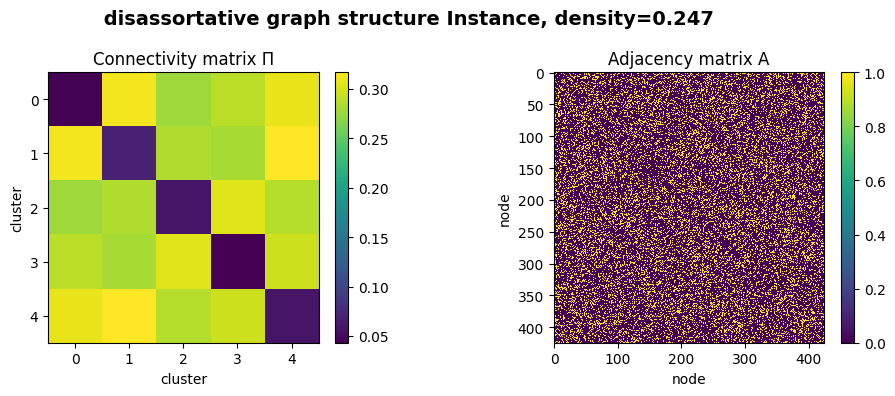

In [ ]:
Q_clusters = 5
N_nodes = Q_clusters*85  # seems that more nodes enable more redundancy per clusters, which increase their SNR, leading to better clustering
Beta = 0.3

Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label = create_simple_graph(n_nodes=N_nodes, n_clusters=Q_clusters,graph_struct="disassortative", undirected=True, Beta=Beta, Epsi=0.05, Zeta=0.99, shuffle=True, plot=True)
#Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label = create_simple_graph(n_nodes=N_nodes, n_clusters=Q_clusters,graph_struct="assortative", undirected=True, Beta=Beta, Epsi=0.05, Zeta=0.99, shuffle=False, plot=True)
#Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label = create_simple_graph(n_nodes=N_nodes, n_clusters=Q_clusters,graph_struct="hub", undirected=True, Beta=Beta, Epsi=0.05, Zeta=0.99, shuffle=False, plot=True)



Adja_matrix_tensor = torch.from_numpy(Adja_matrix).float()
Pi_connectivity_matrix_tensor = torch.from_numpy(Pi_connectivity_matrix).float()
eta_star = torch.from_numpy(eta_star).float()
nodes_label = torch.from_numpy(nodes_label).float()

Adja_matrix_tensor = Adja_matrix_tensor.to(device)
eta_star_tensor = eta_star.to(device)
true_label_tensor = nodes_label.to(device)


 Assessing DeepLPBM on Q clusters = 1/9
 Assessing DeepLPBM on Q clusters = 2/9
 Assessing DeepLPBM on Q clusters = 3/9
 Assessing DeepLPBM on Q clusters = 4/9
 Assessing DeepLPBM on Q clusters = 5/9
 Assessing DeepLPBM on Q clusters = 6/9
 Assessing DeepLPBM on Q clusters = 7/9
 Assessing DeepLPBM on Q clusters = 8/9
 Assessing DeepLPBM on Q clusters = 9/9


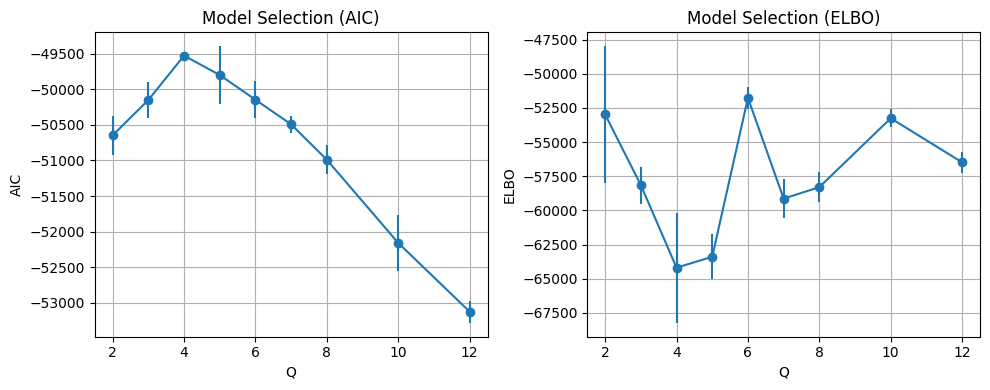

In [ ]:
def AIC_score(loglik, N, Q):
  aic_score = loglik - (Q*(Q+1))//2 - N*(Q-1)
  return aic_score

def BIC_score(loglik, N, Q):
  bic_score = loglik - 0.5*((Q*(Q+1))//2 - N*(Q-1))*np.log((N*(N-1))//2)
  return bic_score


Q_list = [2,3,4,5,6,7,8,10,12]

maxiter_init = 700
maxiter = 1000

n_repeat_selection = 5 # paper mention 10, but that's heavy
model_selection_aic = np.zeros((len(Q_list), n_repeat_selection))
model_selection_bic = np.zeros((len(Q_list), n_repeat_selection))
model_selection_elbo = np.zeros((len(Q_list), n_repeat_selection))
best_aic_per_q  = []
best_bic_per_q  = []
best_elbo_per_q = []

for iq,q in enumerate(Q_list):
  print(f" Assessing DeepLPBM on Q clusters = {iq+1}/{len(Q_list)}")
  best_elbo = -np.inf
  best_aic  = -np.inf
  best_bic  = -np.inf
  for i in range(n_repeat_selection): # the paper advice to initialize with 10 different seed and keep the best/highest ELBO
    torch.manual_seed(i)
    np.random.seed(i)

    N = Adja_matrix_tensor.size(0)
    model = DeepLPBM(N=N, Q=q, H=30)

    Z0, eta0, Pi0 = initialisation(Adja_matrix_tensor,q)
    model, _, _ = pretraining(model, Adja_matrix_tensor, Z0, Pi0, maxiter_init=maxiter_init)
    model, _, _, _, _ = training(model, N, q, Adja_matrix_tensor,true_label_tensor,maxiter=maxiter)


    # Track final AIC
    loglik_hat, _, _, _, _ = model.get_map_loglikeli(Adja_matrix_tensor)
    aic = AIC_score(loglik_hat.item(), N, q)
    model_selection_aic[iq, i] = aic
    bic = BIC_score(loglik_hat.item(), N, q)
    model_selection_bic[iq, i] = bic

    # Track final ELBO
    elbo, recon, kl = model.elbo(Adja_matrix_tensor)
    model_selection_elbo[iq, i] = elbo.item()
    if elbo.item() > best_elbo:
            best_elbo = elbo.item()
            best_aic  = aic
            best_bic  = bic
  best_elbo_per_q.append(best_elbo)
  best_aic_per_q.append(best_aic)
  best_bic_per_q.append(best_bic)



### Plot with error bar
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(Q_list, model_selection_aic.mean(axis=1),yerr=model_selection_aic.std(axis=1), fmt='o-')
axes[0].set_xlabel('Q')
axes[0].set_ylabel('AIC')
axes[0].set_title('Model Selection (AIC)')
axes[0].grid(True)

axes[1].errorbar(Q_list, model_selection_elbo.mean(axis=1),yerr=model_selection_elbo.std(axis=1), fmt='o-')
axes[1].set_xlabel('Q')
axes[1].set_ylabel('ELBO')
#axes[1].set_yscale('log')
axes[1].set_title('Model Selection (ELBO)')
axes[1].grid(True)

plt.tight_layout()
plt.show()




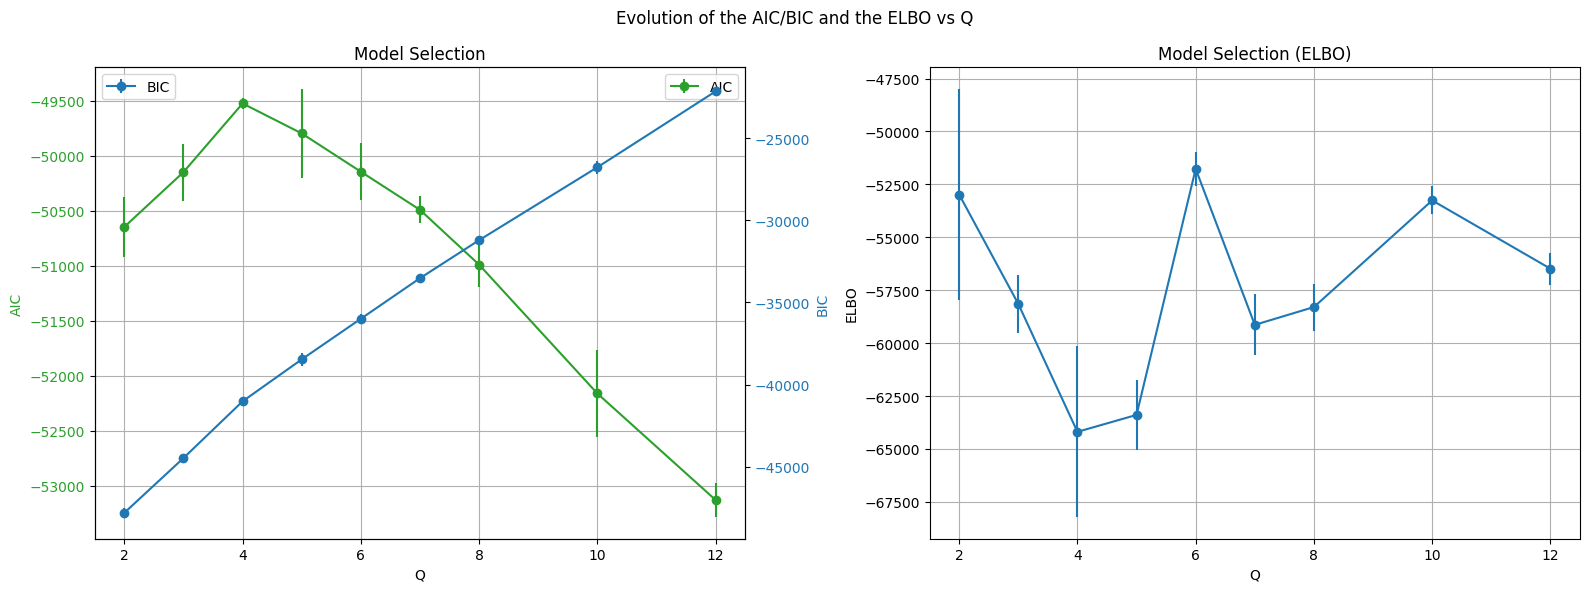

In [ ]:
### Plot with error bar
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 6))

color = 'tab:green'
ax1.errorbar(Q_list, model_selection_aic.mean(axis=1),yerr=model_selection_aic.std(axis=1),color=color, fmt='o-',label="AIC")
ax1.set_xlabel('Q')
ax1.set_ylabel('AIC',color=color)
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.errorbar(Q_list, model_selection_bic.mean(axis=1),yerr=model_selection_aic.std(axis=1),color=color, fmt='o-',label="BIC")
ax2.set_xlabel('Q')
ax2.set_ylabel('BIC',color=color)
ax2.set_title('Model Selection')
ax2.legend()
ax2.tick_params(axis='y', labelcolor=color)


ax3.errorbar(Q_list, model_selection_elbo.mean(axis=1),yerr=model_selection_elbo.std(axis=1), fmt='o-')
ax3.set_xlabel('Q')
ax3.set_ylabel('ELBO')
#axes[1].set_yscale('log')
ax3.set_title('Model Selection (ELBO)')
ax3.grid(True)


fig.suptitle('Evolution of the AIC/BIC and the ELBO vs Q')
plt.tight_layout()
plt.show()


## Final training:

Now that e selected the best number of cluster, do a final training:



In [ ]:

#maxiter_init = 700
#maxiter = 1000


best_iQ = np.unravel_index(np.argmax(model_selection_aic), model_selection_aic.shape)
best_Q = Q_list[best_iQ[0]]
if best_Q != Q_clusters:
  print(" Aïe, Aïe, Aïe.. Found best Q = ", best_Q, ". However, True Q = ", Q_clusters)
Q = Q_clusters
n_repeat_selection = 5

max_elbo = -np.inf
best_elbo_history, best_ari_history, best_epoch_history = None, None, None
ari_across_seed = []
elbo_across_seed = []
for i in range(n_repeat_selection): # the paper advice to initialize with 10 different seed and keep the best/highest ELBO
  torch.manual_seed(311-i)
  np.random.seed(311-i)

  N = Adja_matrix_tensor.size(0)
  model = DeepLPBM(N=N, Q=Q, H=30)

  Z0, eta0, Pi0 = initialisation(Adja_matrix_tensor,Q)
  model, track_loss_pretr, track_epoch_pretr = pretraining(model, Adja_matrix_tensor, Z0, Pi0, maxiter_init=maxiter_init)
  model,elbo_history, ari_history, epoch_history,_ = training(model, N, Q, Adja_matrix_tensor,true_label_tensor, maxiter=maxiter)
  ari_across_seed.append(ari_history)
  elbo_across_seed.append(elbo_history)
  elbo = elbo_history[-1]
  if elbo > max_elbo:
    max_elbo = elbo
    best_model = model
    best_Pi0 = Pi0
    best_elbo_history, best_ari_history, best_epoch_history = elbo_history, ari_history, epoch_history






 Aïe, Aïe, Aïe.. Found best Q =  6 . However, True Q =  5


# Evaluation

(5, 100)


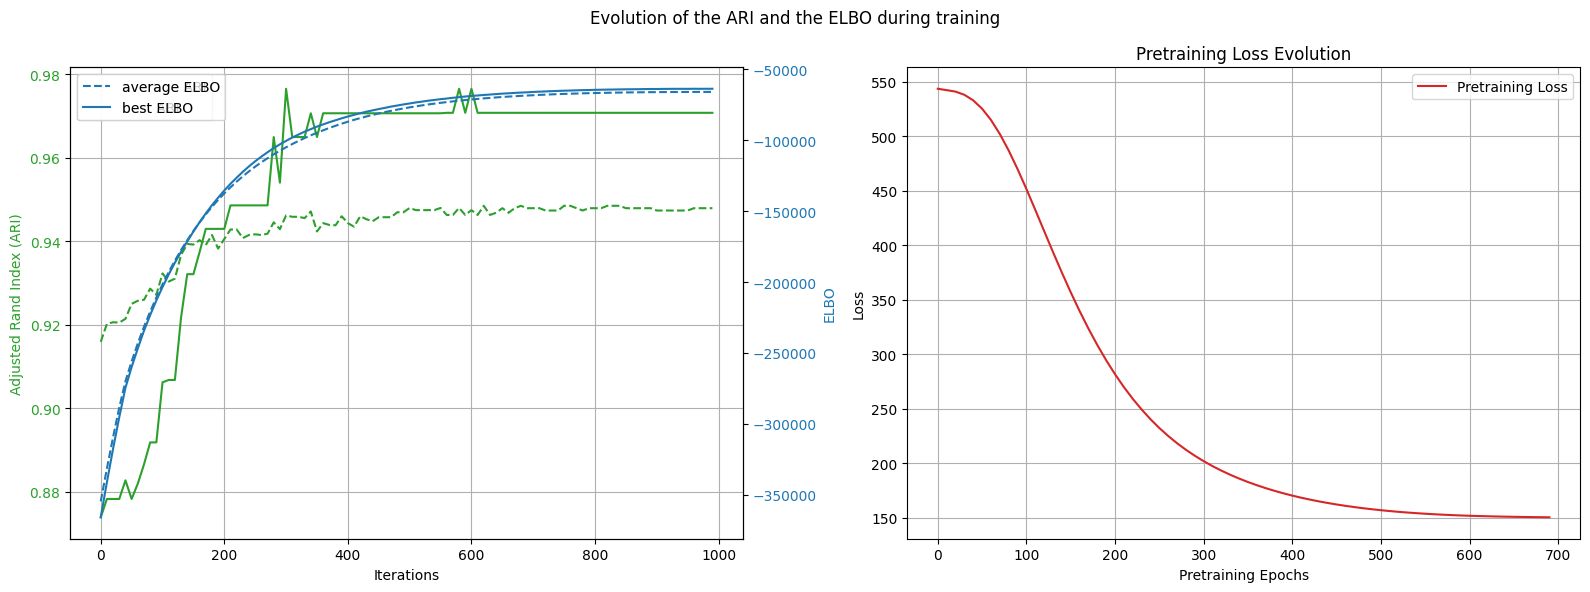

In [ ]:

ari_across_seed = np.array(ari_across_seed)
elbo_across_seed = np.array(elbo_across_seed)

print(ari_across_seed.shape)

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 6))

# Plot ARI
color = 'tab:green'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Adjusted Rand Index (ARI)', color=color)
ax1.plot(epoch_history, ari_across_seed.mean(axis=0),linestyle='--', color=color, label='average ARI')
ax1.plot(epoch_history, best_ari_history, color=color, label='best ARI')
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis for the ELBO
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('ELBO', color=color)
ax2.plot(epoch_history, elbo_across_seed.mean(axis=0),linestyle='--', color=color, label='average ELBO')
ax2.plot(epoch_history, best_elbo_history, color=color, label='best ELBO')
ax2.legend()
ax2.tick_params(axis='y', labelcolor=color)

# Loss of the pretraining
ax3.plot(track_epoch_pretr, track_loss_pretr, color='tab:red', label='Pretraining Loss')
ax3.set_xlabel('Pretraining Epochs')
ax3.set_ylabel('Loss')
ax3.set_title('Pretraining Loss Evolution')
ax3.grid(True)
ax3.legend()

fig.suptitle('Evolution of the ARI and the ELBO during training')
fig.tight_layout()
plt.show()

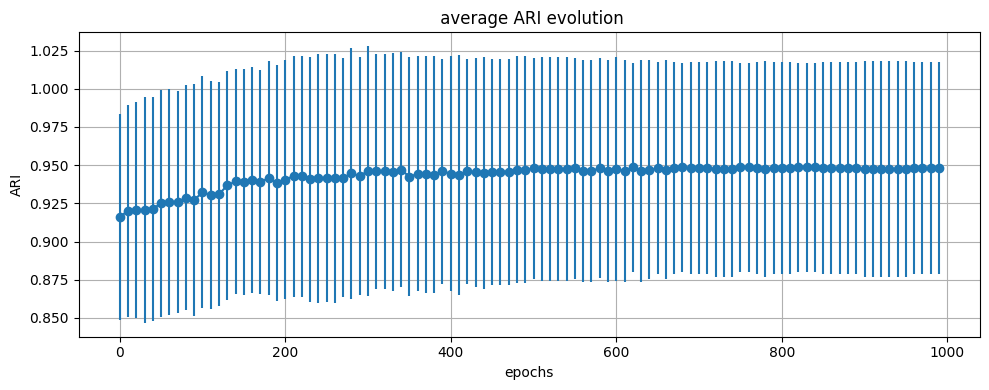

In [ ]:


fig, ax = plt.subplots(figsize=(10, 4))

ax.errorbar(epoch_history, ari_across_seed.mean(axis=0),yerr=ari_across_seed.std(axis=0), fmt='o-')
ax.set_xlabel('epochs')
ax.set_ylabel('ARI')
ax.set_title(' average ARI evolution')
ax.grid(True)


plt.tight_layout()
plt.show()

Frobenius norm of (Pi_hat - Pi_true): 0.0916
Frobenius norm of (Pi_hat_kmean - Pi_true): 0.0832
 Aïe Aïe Aïe .. you found worse clustering with DeepLPBM than Kmean initial step, you'd better review your code !


/tmp/ipython-input-2375265699.py:32: UserWarning:  Actually, Frobenius norm is not invariant to permutaiton, so we need to find the permutation maximising the Frobenius, before to return the Frob norm score .. let's do that!
  warnings.warn(" Actually, Frobenius norm is not invariant to permutaiton, so we need to find the permutation maximising the Frobenius, before to return the Frob norm score .. let's do that!")


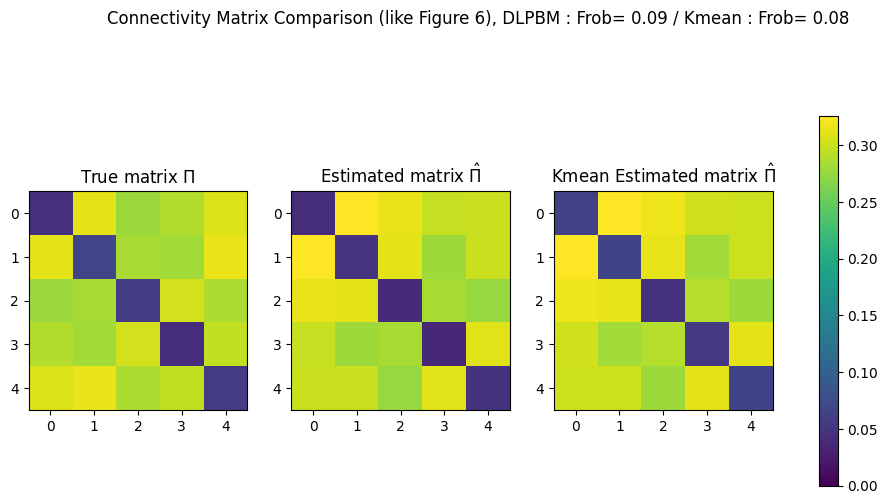

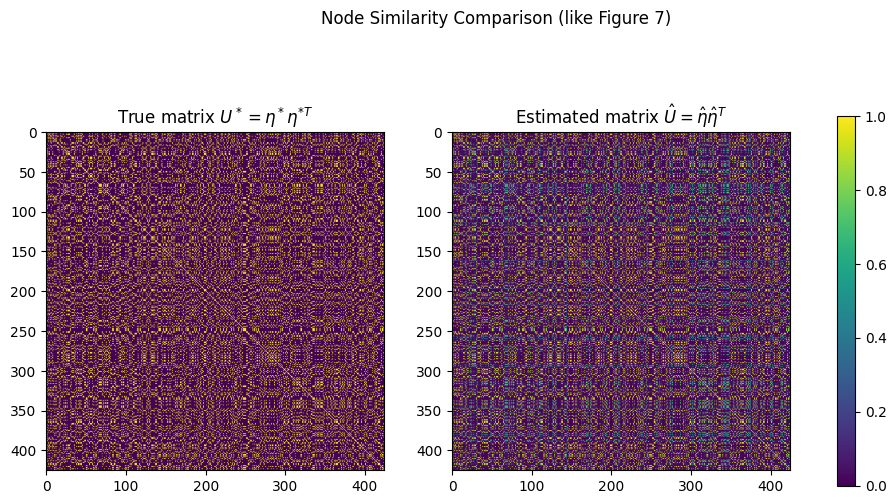

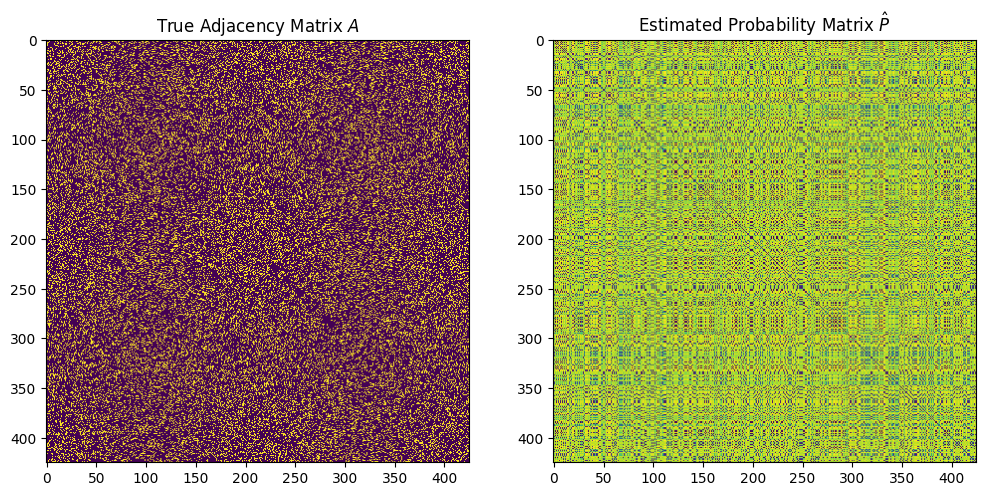

tensor([[9.5734e-01, 6.7886e-03, 3.7027e-04, 3.3618e-02, 1.8813e-03],
        [1.8735e-02, 3.4257e-02, 5.6727e-04, 9.3974e-01, 6.6979e-03],
        [1.4271e-04, 2.0562e-03, 9.9468e-01, 6.7172e-04, 2.4446e-03],
        [3.9253e-04, 9.9265e-01, 1.0573e-03, 4.9054e-03, 9.9945e-04],
        [3.9850e-04, 1.9143e-03, 9.9355e-01, 1.9749e-03, 2.1590e-03],
        [1.2706e-03, 9.1755e-01, 6.9996e-02, 9.0523e-03, 2.1270e-03],
        [9.8527e-01, 2.3013e-03, 6.0670e-03, 5.7290e-03, 6.3517e-04],
        [1.4578e-04, 9.8571e-01, 7.1613e-03, 1.4612e-03, 5.5195e-03],
        [3.6266e-03, 2.7161e-03, 9.7931e-01, 3.0144e-03, 1.1330e-02],
        [8.8114e-04, 9.8733e-01, 1.6866e-03, 9.4807e-03, 6.2545e-04]],
       device='cuda:0')


In [ ]:
def visualize_results(model, A_tensor, true_Pi, eta_star, Pi0_kmean):
  '''
  Visualizes the estimated Pi and U matrices against the true ones, replicating Figures 6 and 7.
  '''
  model.eval()
  with torch.no_grad():

    loglik_hat, P_hat, eta_hat, Pi_hat, mu_hat =  model.get_map_loglikeli(Adja_matrix_tensor)

    # Compute U matrices
    U_hat = eta_hat @ eta_hat.T
    U_true = eta_star @ eta_star.T

    # Detach from GPU/graph
    Pi_hat_np = Pi_hat.cpu().numpy()
    U_hat_np = U_hat.cpu().numpy()
    true_Pi_np = true_Pi.cpu().numpy() if isinstance(true_Pi, torch.Tensor) else true_Pi
    U_true_np = U_true.cpu().numpy() if isinstance(U_true, torch.Tensor) else U_true
    Pi0_kmean_np = Pi0_kmean.cpu().numpy() if isinstance(Pi0_kmean, torch.Tensor) else Pi0_kmean


  # Assess Connectivity Matrix Error (Figure 6)
  frobenius_error_dlpbm = np.linalg.norm(Pi_hat_np - true_Pi_np, 'fro')
  frobenius_error_kmean = np.linalg.norm(Pi0_kmean_np - true_Pi_np, 'fro')
  print(f"Frobenius norm of (Pi_hat - Pi_true): {frobenius_error_dlpbm:.4f}")
  print(f"Frobenius norm of (Pi_hat_kmean - Pi_true): {frobenius_error_kmean:.4f}")

  if frobenius_error_dlpbm > frobenius_error_kmean:
    print(" Aïe Aïe Aïe .. you found worse clustering with DeepLPBM than Kmean initial step, you'd better review your code !")


  warnings.warn(" Actually, Frobenius norm is not invariant to permutaiton, so we need to find the permutation maximising the Frobenius, before to return the Frob norm score .. let's do that!")


  fig, axes = plt.subplots(1, 3, figsize=(12, 6))
  im1 = axes[0].imshow(true_Pi_np, vmin=0, vmax=max(true_Pi_np.max(), Pi_hat_np.max()))
  axes[0].set_title(r"True matrix $\Pi$")
  im2 = axes[1].imshow(Pi_hat_np, vmin=0, vmax=max(true_Pi_np.max(), Pi_hat_np.max()))
  axes[1].set_title(r"Estimated matrix $\hat{\Pi}$")
  im3 = axes[2].imshow(Pi0_kmean_np, vmin=0, vmax=max(true_Pi_np.max(), Pi0_kmean_np.max()))
  axes[2].set_title(r"Kmean Estimated matrix $\hat{\Pi}$")
  fig.colorbar(im1, ax=axes, shrink=0.8)
  fig.suptitle(f"Connectivity Matrix Comparison (like Figure 6), DLPBM : Frob= {frobenius_error_dlpbm:.2f} / Kmean : Frob= {frobenius_error_kmean:.2f}")
  plt.show()

  # Assess Node Similarity Matrix (Figure 7)
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  im1 = axes[0].imshow(U_true_np, vmin=0, vmax=1)
  axes[0].set_title(r"True matrix $U^* = \eta^*\eta^{*T}$")
  im2 = axes[1].imshow(U_hat_np, vmin=0, vmax=1)
  axes[1].set_title(r"Estimated matrix $\hat{U} = \hat{\eta}\hat{\eta}^T$")
  fig.colorbar(im1, ax=axes, shrink=0.8)
  fig.suptitle("Node Similarity Comparison (like Figure 7)")
  plt.show()

  # Visualize Estimated Adjacency (like Figure 4)
  with torch.no_grad():
      P_hat, _, _ = model.decoder(eta_hat)
      P_hat_np = P_hat.cpu().numpy()

  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  axes[0].imshow(A_tensor.cpu().numpy(), cmap='viridis')
  axes[0].set_title(r"True Adjacency Matrix $A$")
  axes[1].imshow(P_hat_np, cmap='viridis')
  axes[1].set_title(r"Estimated Probability Matrix $\hat{P}$")
  plt.show()

  return eta_hat, Pi_hat, U_hat


eta_hat, Pi_hat, U_hat = visualize_results(best_model, Adja_matrix_tensor, Pi_connectivity_matrix_tensor, eta_star_tensor, best_Pi0)

print(eta_hat[:10])

#### $\Pi$ evolution

Let's track $\Pi$ evolution because $\Pi_{Kmean}$ and $\Pi_{hat}$ look very similar, which can be suspicious (e.g. untrained decoder or vanishing gradient)


<>:27: SyntaxWarning: invalid escape sequence '\P'
<>:27: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-1740575976.py:27: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Probability of Connection ($\Pi_{qr}$)")


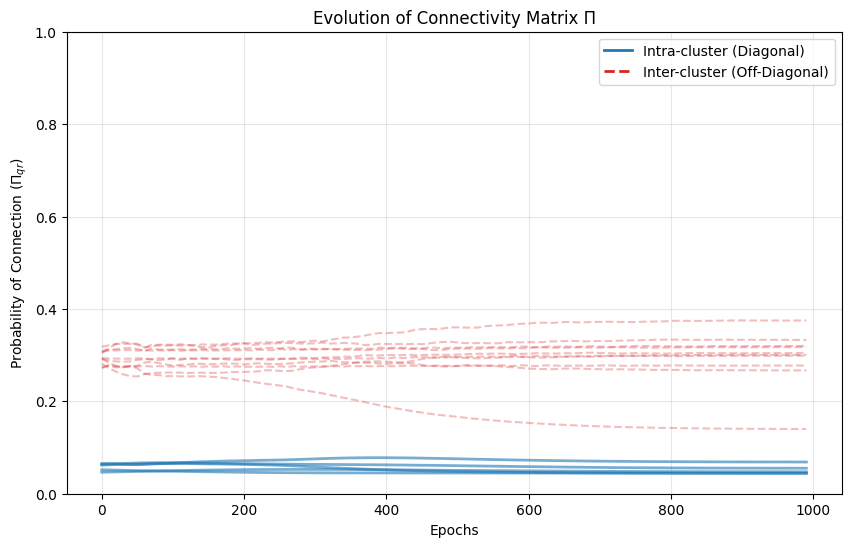

In [ ]:
def plot_pi_evolution(pi_history, epoch_list, title="Evolution of Connectivity Matrix Π"):
  '''
  Plots the values of Pi over training epochs.
  '''
  Q = pi_history.shape[1]

  # Extract Diagonals (Intra-cluster probabilities)
  diagonals = np.diagonal(pi_history, axis1=1, axis2=2)

  # Extract Off-Diagonals (Inter-cluster probabilities)
  mask_off = ~np.eye(Q, dtype=bool)

  fig, ax = plt.subplots(figsize=(10, 6))
  for q in range(Q): # Plot Diagonals
    ax.plot(epoch_list, diagonals[:, q],
        label=f'Intra-cluster {q+1}' if q == 0 else None,
        color='tab:blue', alpha=0.6, linewidth=2)

  for q in range(Q): # Plot Off-Diagonals
    for r in range(q + 1, Q):
      val_curve = pi_history[:, q, r]
      ax.plot(epoch_list, val_curve,
          linestyle='--', color='tab:red', alpha=0.3,
          label='Inter-cluster' if (q==0 and r==1) else None)

  ax.set_xlabel("Epochs")
  ax.set_ylabel("Probability of Connection ($\Pi_{qr}$)")
  ax.set_title(title)
  ax.set_ylim(0, 1)

  # Custom Legend
  custom_lines = [Line2D([0], [0], color='tab:blue', lw=2),Line2D([0], [0], color='tab:red', lw=2, linestyle='--')]
  ax.legend(custom_lines, ['Intra-cluster (Diagonal)', 'Inter-cluster (Off-Diagonal)'])

  ax.grid(True, alpha=0.3)
  plt.show()


torch.manual_seed(i)
np.random.seed(i)

N = Adja_matrix_tensor.size(0)
model = DeepLPBM(N=N, Q=Q, H=30)

Z0, eta0, Pi0 = initialisation(Adja_matrix_tensor,Q)
model, _, _ = pretraining(model, Adja_matrix_tensor, Z0, Pi0, maxiter_init=maxiter_init)
model, elbo_hist, ari_hist, epochs, pi_hist = training(model, N, Q, Adja_matrix_tensor, true_label_tensor, maxiter=maxiter,tracking=True)
plot_pi_evolution(pi_hist, epochs)

#### Induction of the ELBO evolution of the paper

Here, we plotted a rougth estimation of the figure9 of the paper, so that we could visualize the evolution of the LogLikelihood of the original model, and compare it's tendancy to our model.

In fact, we had to do that because our model doesn't succeed in reproducing the results of the paper, so we need to figure out where are the difference.

**conlcusion:** Our model procudes a loglikelihood tendancy very different from their model, because our loglikeli is not steadily increasing with Q increasing (green curve below). Now, let's figure out why (would be easier if they made their code public available ...).

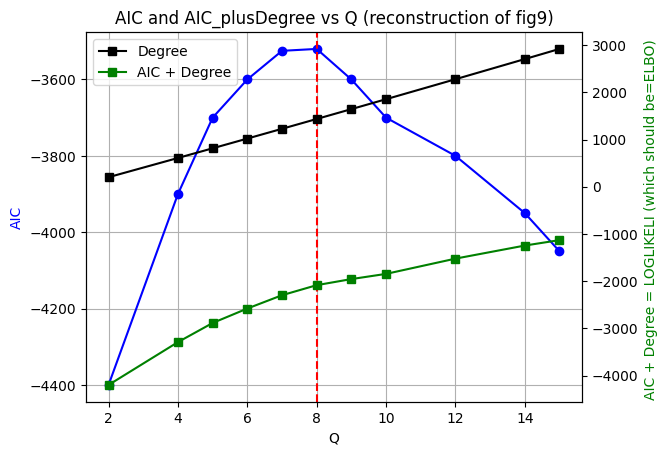

In [ ]:

# Rough reconstruction fig 9
Q_list = [2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15]
Degree_list = [q*(q+1)//2 + 200*(q-1) for q in Q_list]
AIC_list = [-4400, -3900, -3700, -3600, -3525, -3520, -3600, -3700, -3800, -3950, -4050]
AIC_plusDegree_list = [aic + degree for aic, degree in zip(AIC_list, Degree_list)]

fig, ax1 = plt.subplots()

ax1.plot(Q_list, AIC_list, marker='o', color='blue', label='AIC')
ax1.axvline(8, linestyle='--', color='red')
ax1.set_xlabel("Q")
ax1.set_ylabel("AIC", color='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(Q_list, Degree_list, marker='s', color='black', label='Degree')
ax2.plot(Q_list, AIC_plusDegree_list, marker='s', color='green', label='AIC + Degree')
ax2.set_ylabel("AIC + Degree = LOGLIKELI (which should be=ELBO) ", color='green')
plt.legend()
plt.title("AIC and AIC_plusDegree vs Q (reconstruction of fig9)")
plt.show()


# Visualization


The visualization is generated by projecting the estimated partial membership vectors (η_hat​) into a 2D space using t-SNE (section 6.1).


<>:83: SyntaxWarning: invalid escape sequence '\h'
<>:83: SyntaxWarning: invalid escape sequence '\e'
<>:83: SyntaxWarning: invalid escape sequence '\h'
<>:83: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-242727129.py:83: SyntaxWarning: invalid escape sequence '\h'
  plt.title(f"{title}\n(t-SNE projection of $\hat{{\eta}}$)")
/tmp/ipython-input-242727129.py:83: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f"{title}\n(t-SNE projection of $\hat{{\eta}}$)")
/tmp/ipython-input-242727129.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', Q).colors


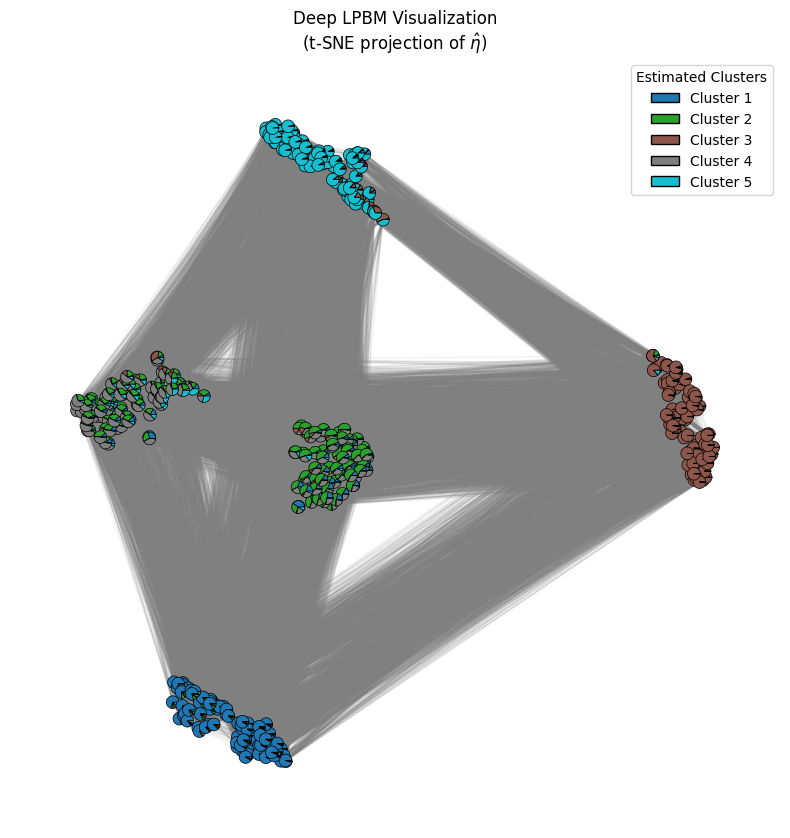

In [ ]:


def get_tsne_layout(eta_hat,projector="TSNE",random_state=42):
  '''
  Projects the (N,Q) partial membership matrix into 2D space using t-SNE
  as described in Section 6.1 of the paper.
  '''

  if isinstance(eta_hat, torch.Tensor):
      eta_np = eta_hat.detach().cpu().numpy() # make eta compatible to tsne numpy

  if projector == "UMAP":
    tsne = umap.UMAP(n_components=2, random_state=random_state)
    pos_2d = tsne.fit_transform(eta_np)
  elif projector == "TSNE":
    tsne = TSNE(n_components=2, perplexity=30, random_state=random_state, init='pca', learning_rate='auto')
    pos_2d = tsne.fit_transform(eta_np)
  else:
    raise ValueError("Invalid projector. You have to choose 'UMAP' or 'TSNE' ..")

  # Normalize to [0, 1] for easier plotting
  pos_2d = (pos_2d - pos_2d.min(0)) / (pos_2d.max(0) - pos_2d.min(0)) # should be size (N,2)
  return pos_2d


def draw_pie_marker(ax, x, y, ratios, size=0.02, colors=None):
  '''
  Draws a pie chart at the vertices (coordinates (x,y)) with the given ratios, as they did in the paper

  credit: Gemini3
  '''
  xy = [x, y]
  start = 0.0
  for ratio, color in zip(ratios, colors):
      # draw wedges (pie slices) manually
      wedge = matplotlib.patches.Wedge(
          center=xy, r=size,
          theta1=start * 360.0,
          theta2=(start + ratio) * 360.0,
          facecolor=color,
          edgecolor='black',
          linewidth=0.5
      )
      ax.add_patch(wedge)
      start += ratio


def visualize_deep_lpbm_network(A_tensor, eta_hat_tensor,projector="TSNE", title="Deep LPBM Visualization"):
  '''
  Replicates (like in Figure 11(b) from the paper).
  Parameters-->
  -A_tensor: Adjacency matrix (N,N)
  -eta_hat_tensor: Estimated partial memberships (N,Q)
  '''

  A_np = A_tensor.cpu().numpy()
  eta_np = eta_hat_tensor.cpu().detach().numpy()
  N, Q = eta_np.shape

  # Compute Layout using t-SNE on eta
  layout_pos = get_tsne_layout(eta_hat_tensor,projector=projector)

  # Plot
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.set_aspect('equal')
  ax.axis('off')

  # Draw Edges
  G = nx.from_numpy_array(A_np) # networkx for efficient edge drawing
  tsne_coords_dict = {i: layout_pos[i] for i in range(N)}
  nx.draw_networkx_edges(G, tsne_coords_dict, ax=ax, alpha=0.1, edge_color='gray')

  # Draw Nodes as Pie Charts
  cluster_colors = plt.cm.get_cmap('tab10', Q).colors
  pie_size = 0.02 if N < 200 else 0.01

  for i in range(N): # draw nodes per nodes
      x, y = layout_pos[i]
      ratios = eta_np[i] # Get membership distribution for node i
      draw_pie_marker(ax, x, y, ratios, size=pie_size, colors=cluster_colors)

  legend_elements = [matplotlib.patches.Patch(facecolor=cluster_colors[i], edgecolor='k', label=f'Cluster {i+1}') for i in range(Q)] # legend
  ax.legend(handles=legend_elements, loc='upper right', title="Estimated Clusters")

  plt.title(f"{title}\n(t-SNE projection of $\hat{{\eta}}$)")
  plt.show()



best_model.eval() # Or we can just call eta_hat, from last outputs
with torch.no_grad():
    _, _, eta_hat, _, _ = best_model.get_map_loglikeli(Adja_matrix_tensor)


visualize_deep_lpbm_network(Adja_matrix_tensor, eta_hat,projector="TSNE")


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-242727129.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', Q).colors


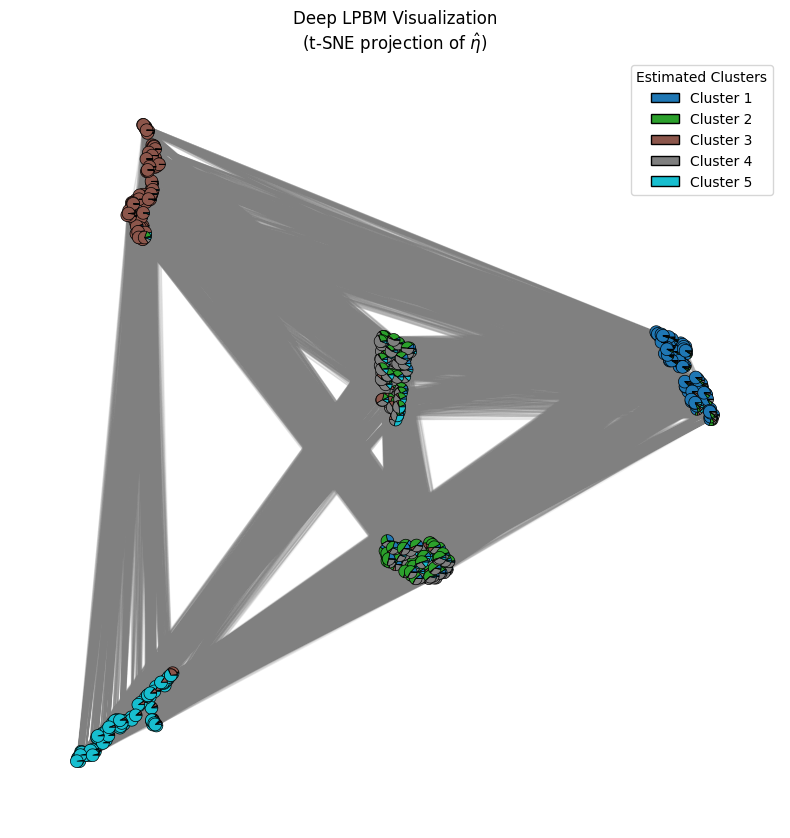

In [ ]:
visualize_deep_lpbm_network(Adja_matrix_tensor, eta_hat,projector="UMAP")